In [1]:
#import sys
#sys.path.append('C:\\Users\\mabdalla\\OneDrive - ec-lyon.fr\\Documents\\Python Scripts\\packages')
import torch
import numpy as np
import photontorch as pt
from photontorch.environment import current_environment
import matplotlib.pyplot as plt
from scipy.signal import butter#, lfilter
from torch_lfilter import lfilter
import pandas as pd
from photontorch import BoundedParameter
from ipywidgets import interact
from tqdm.notebook import trange

### Now we proceed to construct the missing components: PD, 3-Port MZI, Electronic Combiner, AWG, Optical Attenuator. In additon we need to construct a CW Laser as Photontorch networks do not handle different instances of sources independently within the same simulation

In [2]:
class PD(pt.Component):
    """
    A photodector which acts instantaneously on the input optical power,
    converting it to current according to the input wavelength-independendt responsivity.
    Note: At R=1, this is the equivalent component of the built-in detector term.
    An optional Resistance can be added to output a voltage instead, to model a simple TIA operating at DC.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        R = 1, #Responsivity
        Z = 1, #TIA Impedence (Resistance)
        name = None,  
        ):
        
        super(PD,self).__init__(name=name)    
        self.R = float(R)
        self.Z = float(Z)
        
    def action(self, t, x_in, x_out):
        
        a_in, _ = x_in

        x_out[0] = a_in  #Nothing happens to input node
        
        
        x_out[1,0] = self.R*self.Z*(a_in[0]**2+a_in[1]**2)  #PD Equation
        
        x_out[1,1] = 0  #lose the phase information
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [3]:
class MZI(pt.Component):
    """
    This is a 3 port implementation of symmetric MZI-based (equal arm-lengths) Intensity modulator. 
    An input voltage adds a phase to the phase induced by one of the arms.
    Note: This implementation assumes it will be connected to a real source.

    Terms: 
  Optical  0 ----- 2  Optical
               |
               |
               1 
           Electrical
    
    """    
    num_ports = 3
    
    def __init__(
        self,
        vpi = 3.0, #Voltage to acquire Pi phase shift
        neff = 2.34, #effective index
        ng = 3.40, #group index
        wl0 = 1.55e-6, #wavelength for defined neff
        length = 1.5e-6, #waveguide length (m)
        loss = 0, #The loss would be both Y-jun loss + both waveguide losses
        name = None,  
        ):
        
        super(MZI,self).__init__(name=name)    
        self.vpi=float(vpi)
        self.neff = float(neff)
        self.ng = float(ng)
        self.length = float(length)
        self.loss = float(loss)
        self.wl0 = float(wl0)
        
    #def set_delays(self,delays):
        #delays[:] = self.ng * self.length/self.env.c
        
    def action(self, t, x_in, x_out):
        
        a_in, v_in, _ = x_in     #Port0: input optical amplitude, Port1: input Voltage, Port2: O/p node (no need to store)
        
        v = v_in[0]  #The 'real' part of voltage signal 
        #print(a_in)  #for debugging
        
        x_out[0] = a_in  #Nothing happens to optical input node
        
        x_out[1] = v_in #Nothing happens to electrical input port
        
        wls = torch.tensor(self.env.wl, dtype=torch.float64, device=self.device)

        # neff depends on the wavelength:
        neff = self.neff - (wls - self.wl0) * (self.ng - self.neff) / self.wl0
        
        phase = (2 * np.pi * neff * self.length / wls) #% (2 * np.pi) #Phase due to waveguide propagation
        
        Ei = torch.sqrt(a_in[0]**2 + a_in[1]**2) #Input amplitude

        mzi_eq_re = 0.5 * Ei * (torch.cos(phase) + torch.cos(phase + np.pi * (v / self.vpi)))  #Real
        mzi_eq_im = 0.5 * Ei * (torch.sin(phase) + torch.sin(phase + np.pi * (v / self.vpi))) #Imaginary
        
        x_out[2,0] = mzi_eq_re  
        x_out[2,1] = mzi_eq_im
        
        #print(x_out[2])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1  #Actions must be defined for all ports in active devices
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        S[0,:,2,2] = 1.0
        return S

In [4]:
class optAtten(pt.Component):
    """
    The optical attenuator is a 2 port component that attenuates the signal. It is bounded from 0 to 1.
    The attenuation is trainable.
    
    Terms: 
    Optical  0 ----- 1  Optical
            
    """      
    num_ports = 2
    
    def __init__(
    self,
    trainable = True,
    attenuation = 0.0,
    name=None,
    ): 
        #self.attenuation = float(attenuation)
        super(optAtten, self).__init__(name=name)
        if trainable:
            self.attenuation = BoundedParameter(
            data=torch.tensor(attenuation, device=self.device),
            bounds=(0.0, 1.0),
            requires_grad=True,
            )
        else:
            self.attenuation = Buffer(
            data=torch.tensor(attenuation, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,0,1] = S[0,:,1,0] = (1.0-self.attenuation) ** 0.5

        return S

In [5]:
class Combiner(pt.Component):
    """
    The electronic combiner is a 3 port component that linearly combines 2 signals then multiplies both by a gain factor.
    The gain is trainable. Note: The circuit is not symmetric.
    Note: The signals entering the i/p ports must be real (Electrical)
    
    Terms: 
  Electrical i/p  0 ----- 2  Electrical o/p
                      |
                      |
                      1 
                 Electrical i/p
            
    """      
    num_ports = 3
    
    def __init__(
    self,
    trainable = True,
    gain = 1.0,
    name=None,
    ): 
        super(Combiner, self).__init__(name=name)
        if trainable:
            self.gain = BoundedParameter(
            data=torch.tensor(gain, device=self.device),
            bounds=(1.0, 30.0),
            requires_grad=True,
            )
        else:
            self.gain = Buffer(
            data=torch.tensor(gain, device=self.device), requires_grad=False
            )
    
    def set_S(self, S):
        S[0,:,2,0] = S[0,:,2,1] = self.gain ** 0.5
        return S

In [6]:
class AWG(pt.Component):
    """
    The AWG produces a sinusoidal signal matching the environment timestep. It is used as an electronic waveform.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        delay = 0,
        name = None,  
        ):
        
        super(AWG,self).__init__(name=name) 
        self.delay = float(delay)
        
    def action(self, t, x_in, x_out):
        
        sin_source = np.sin(t*4e13)
        
        if t<self.delay:
            x_out[1,0] = 0 
        else:
            x_out[1,0] = sin_source
        
        x_out[1,1] = 0  #no phase information
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

In [7]:
class CW_Laser(pt.Component):
    """
    A CW Laser used when multiple sources are desired in a network. Note: When linking, terminate the component's 0 port.

    Terms: 
        0 ---- 1 
    
    """    
    num_ports = 2
    
    def __init__(
        self,
        Power = 1,  #Input the laser power here
        delay=0,
        name = None,  
        ):
        
        super(CW_Laser,self).__init__(name=name) 
        self.Power = float(Power)
        self.delay = float(delay)
            
    def action(self, t, x_in, x_out):
        
        if t<self.delay:
            x_out[1,0] = 0.0001  #Zero noise floor
        else:
            x_out[1,0] = self.Power ** 0.5
        
        x_out[1,1] = 0  #no phase information, this is a real source
        
        #print(x_out[1,0])  #for debugging
        
    def set_actions_at(self, actions_at):
        actions_at[:] = 1
        
    def set_S(self, S):
        S[0,:,0,0] = 1.0
        S[0,:,1,1] = 1.0
        return S

### After testing each component successfully, now let us proceed to construct our optoelectronic reservoir

#### Fading Memory Property is demonstrated above: The AWG delay is set for the entire simulation duration, such that only the feedback state appears at the output. Tweaking the attenuation + gain should result in different linear (and possibly nonlinear) memory capacities.

In [8]:
class oe_reservoir(pt.Network):
    def __init__(self,gain=3, las_pow = 1, attenuation=0.3, wg_delay=2e-11, wg_ng=2.34):
        super(oe_reservoir, self).__init__()
        self.src = pt.Source()
        self.det = pt.Detector()
        self.pd = PD(Z=1)
        self.comb = Combiner(gain=np.random.uniform(low=1.0,high=30.0), trainable = True)
        self.att = optAtten(attenuation=0.999, trainable = True) #np.random.uniform(low=0.0,high=1.0)
        self.laser = CW_Laser(Power=las_pow, delay=0) #0.15e-9
        self.term = pt.Term()
        self.mmi = pt.Mmi(trainable=False)
        self.wg = pt.Waveguide(ng=wg_ng,length=299792458*wg_delay/wg_ng, trainable = False)
        self.mzi = MZI()
        self.link("term:0","0:laser:1", "0:mzi:2", "0:mmi:1", "0:att:1", "0:wg:1", "0:pd:1", "0:comb:2", "1:mzi")
        self.link("mmi:2", "0:det")
        self.link("src:0","1:comb")
print(torch.where(oe_reservoir().free_ports_at)[0]) 

(1/(299792458*2e-11/2.34))*(299792458/2.34)
(299792458*2e-11/2.34)
299792458/(0.0025623287008547007*2.34)

Buffer containing:
tensor([], dtype=torch.int64)


50000000000.00001

BoundedParameter in [1.00, 30.00] representing:
tensor(28.3722)
BoundedParameter in [0.00, 1.00] representing:
tensor(0.9990)


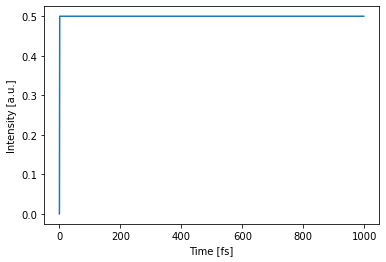

In [9]:
#Reservoir Parameters
delay_wg = 2e-11  #Delay line, it automatically controls the waveguide length (Along with group index below)
ng = 2.34  #To use the parameters of LNOI
gain = 5 #feedback gain
att = 0.4  #optical attenuator
las_pow = 1 #Laser Power

#Simulation parameters -- Control the number of samples here
N = 1000     #no. of 'virtual' nodes in the reservoir
sim_time = 1e-12
wl = 1.55e-6
dt = sim_time/N #timestep

Reservoir = oe_reservoir(gain,las_pow,att,delay_wg,ng)

time_env = pt.Environment(dt=dt, t1=sim_time, wl=wl)

sin_source = torch.tensor(np.sin(time_env.time*4e13), dtype=torch.float32, names=["t"]) # lower dimensional source 

for p in Reservoir.parameters():
    print(p)
with time_env:
    detected = Reservoir(source=0)  ###Write the desired input Power value here
    Reservoir.plot(detected)
    plt.show()

# We now proceed to train the circuit for XOR with 2 subsequent bits

In [100]:
c = 299792458.0 #[m/s] speed of light
Rb = 50e9 #[1/s] bitrate
Rs = 700e9 #[1/s] samplerate  e9 originally
fc = 40e9 #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9 #[m] center wavelength
neff = 2.34 #[1] effective index
ng = 2.34 #[1] group index
N = 100 #[1] number of bits per bit stream
B = 10 #[1] number of bit streams in training batch
Str, Sva, Ste = (1, 2, 3) #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng) #[m] reference length (distance the signal travels during one bit period)
device = torch.device("cpu") # default device used
torch.set_default_dtype(torch.float32) # default dtype used
torch.manual_seed(123) # pytorch seed
np.random.seed(42) # numpy seed
print(Lr)

0.002562328700854701


In [101]:
class BitGenerator(np.random.RandomState):
    def __call__(self, N, B=1):
        """ generate a bit sequence

        Args:
            N: number of bits per sequence
            B: number of sequences in batch
        """
        bits = self.rand(N,B) > 0.5
        return bits

In [102]:
def COPY(bits):
    return bits.copy()
def XOR(bits):
    XOR_res = (np.concatenate([bits, np.zeros_like(bits[-1:])], 0) ^ np.concatenate([np.zeros_like(bits[:1]), bits], 0))[:-1]
    return np.invert(XOR_res)
def AND(bits):
    return (np.concatenate([bits, np.zeros_like(bits[-1:])], 0) & np.concatenate([np.zeros_like(bits[:1]), bits], 0))[:-1]

TARGET = XOR
TARGET(bits)

array([[False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False]])

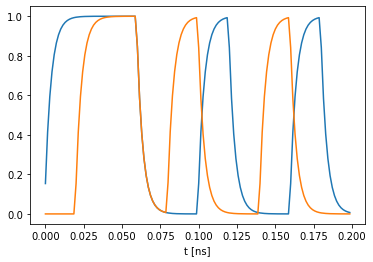

In [103]:
bits = BitGenerator(seed=23)(10)
streamgen = pt.BitStreamGenerator(bitrate=Rb, samplerate=Rs, cutoff_frequency=fc, device=device)
stream = streamgen(bits)
target = streamgen(TARGET(bits))
t = np.arange(stream.shape[0])*(1/Rs)
plt.plot(1e9*t, stream.data.cpu().numpy())
plt.plot(1e9*t, target.data.cpu().numpy())
plt.xlabel("t [ns]")
plt.show()
#streamgen(TARGET(bits))

In [104]:
# train streams
trbits = BitGenerator(seed=Str)(N, B) # N bits per train stream, B train streams per batch.
trstream = streamgen(trbits)
trtarget = streamgen(TARGET(trbits))**2
t = np.arange(trstream.shape[0])*(1/Rs)
#print(t)
# validation streams
vabits = BitGenerator(seed=Sva)(N, 1) # N bits per validation stream, 1 validation stream per batch.
vastream = streamgen(vabits)
vatarget = streamgen(TARGET(vabits))**2

# test streams
tebits = BitGenerator(seed=Ste)(N*B, 1) # N*B bits per teststream
testream = streamgen(tebits)
tetarget = streamgen(TARGET(tebits))**2

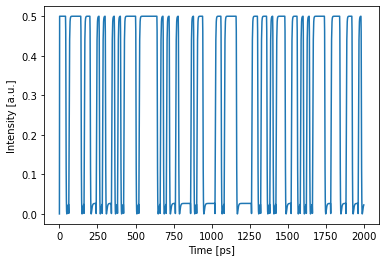

In [105]:
#Reservoir Parameters
delay_wg = 2e-11  #Delay line, it automatically controls the waveguide length (Along with group index below)
ng = 2.34  #To use the parameters of LNOI
gain = 5 #feedback gain
att = 0.4  #optical attenuator
las_pow = 1 #Laser Power

#Simulation parameters -- Control the number of samples here
N = 1000     #no. of 'virtual' nodes in the reservoir
sim_time = 10e-12
wl = 1.55e-6
dt = sim_time/N #timestep

Reservoir = oe_reservoir()

time_env = pt.Environment(dt=dt, t1=sim_time, wl=wl)

sin_source = torch.tensor(np.sin(time_env.time*4e13), dtype=torch.float32, names=["t"]) # lower dimensional source 


with pt.Environment(t=t):
    detected = Reservoir(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
    Reservoir.plot(detected)
    plt.show()

In [106]:
res = oe_reservoir()
with pt.Environment(t=t):
    detected = res(source=vastream.rename("t", "b"))[:,0,0,:] # lower dimensional sources should have named dimensions
#The 2 times as we sample from reservoir at half total power (due to splitting)

mse = pt.MSELoss(latency=0.0, warmup=0.0, bitrate=Rb, samplerate=Rs)
@interact(latency=(0,3,0.5))
def _(latency=1.0):
    mse.plot(vastream, label="input")
    mse.plot(vatarget, label="target")
    mse.plot(detected, latency=latency, label="detected")
    plt.legend()
    plt.xlim(0,0.3)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='latency', max=3.0, step=0.5), Output()), _dom_classe…

In [107]:
mse = pt.MSELoss(latency=0.0, warmup=0.0, bitrate=Rb, samplerate=Rs)
ber = pt.BERLoss(latency=0.0, threshold=0.5, warmup=0.0, bitrate=Rb, samplerate=Rs)

In [108]:
scale = torch.tensor(1.0, requires_grad=True)
bias = torch.tensor(0.0, requires_grad=True)
optim = torch.optim.Adam([scale, bias, *res.parameters()], lr=0.2)
range_ = trange(50)
with pt.Environment(t=t, enable_grad=True):
    for i in range_:
        optim.zero_grad()
        trdet = res(source=trstream.rename("t", "b"))[:,0,0,:]*scale + bias
        loss = mse(trdet, trtarget)
        loss.backward()
        optim.step()
        range_.set_postfix(loss=loss.item(), ber=ber(trdet, trtarget))

  0%|          | 0/50 [00:00<?, ?it/s]

ber:	0.0
mse:	0.16546007990837097


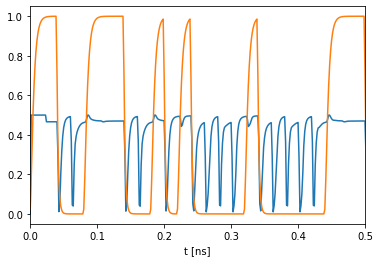

In [109]:
with pt.Environment(t=t):
    vadet = res(source=vastream.rename("t", "b"))[:,0,0,:]
    ber_err = ber(vadet, vatarget, threshold=float((0.5-bias)/scale))
    mse_err = mse(scale*vadet+bias, vatarget)

    print(f"ber:\t{ber_err}")
    print(f"mse:\t{mse_err.item()}")

    mse.plot(vadet)
    mse.plot(vatarget, latency=0.0)
    plt.xlim(0,0.5)
    plt.xlabel("t [ns]")
    plt.show()

In [ ]:
#Export to be plotted in MATLAB

#vadet = vadet.numpy()
det_data = pd.DataFrame(vadet)
det_data.to_csv('det.csv')

#vatarget = vatarget.numpy()
target_data = pd.DataFrame(vatarget)
target_data.to_csv('target.csv')

In [ ]:
#Export to be plotted in MATLAB

#vadet = vadet.numpy()
det_data = pd.DataFrame(vadet)
det_data.to_csv('det1.csv')

#vatarget = vatarget.numpy()
target_data = pd.DataFrame(vatarget)
target_data.to_csv('target1.csv')